In [1]:
pip install tensorflow

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install wordcloud matplotlib

  Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached pillow-11.2.1-cp312-cp312-win_amd64.whl.metadata (9.1 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl (301 kB)
Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pillow-11.2.1-cp312-cp312-win_


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input, Dense, Embedding, Dot, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler,TensorBoard

from wordcloud import WordCloud
%matplotlib inline

#### Reading data

In [3]:
import os

In [4]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [5]:
rating_df = pd.read_csv(os.path.join(INPUT_DIR, "animelist.csv") , low_memory=True,usecols=["user_id","anime_id","rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
rating_df.describe()

,user_id,anime_id,rating
count,5.000000e+06,5.000000e+06,5.000000e+06
mean,8.339305e+03,1.657369e+04,4.306854e+00
std,4.742759e+03,1.379504e+04,3.906990e+00
min,0.000000e+00,1.000000e+00,0.000000e+00
25%,4.291000e+03,3.297000e+03,0.000000e+00
50%,8.378000e+03,1.254900e+04,6.000000e+00
75%,1.242100e+04,3.091100e+04,8.000000e+00
max,1.650800e+04,4.849100e+04,1.000000e+01


#### Data Processing

In [62]:
n_user = rating_df['user_id'].value_counts()

In [63]:
n_user

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
11167      400
11932      400
4125       400
4529       400
5375       400
Name: count, Length: 4203, dtype: int64

In [64]:
rating_df = rating_df[rating_df["user_id"].isin(n_user[n_user>=400].index)].copy()

In [14]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [15]:
len(rating_df)

3246641

In [19]:
min_rating = min(rating_df["rating"])
max_rating = max(rating_df["rating"])
avg_rating = np.mean(rating_df["rating"])

In [20]:
avg_rating

np.float64(4.122732695114736)

In [21]:
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating))

In [25]:
np.mean(rating_df['rating'])

np.float64(0.4122732695114729)

In [26]:
rating_df.duplicated().sum()

np.int64(0)

In [27]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [28]:
user_ids = rating_df['user_id'].unique().tolist()

In [32]:
user2user_encoding = {x : i for i,x in enumerate(user_ids)}
user2user_decoding = {i : x for i,x in enumerate(user_ids)}

rating_df["user"] = rating_df['user_id'].map(user2user_encoding)

In [69]:
n_user = len(user_ids)

In [34]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [35]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoding = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoding = {i : x for i,x in enumerate(anime_ids)}

rating_df["anime"] = rating_df['anime_id'].map(anime2anime_encoding)

In [36]:
n_anime = len(anime2anime_encoding)

In [37]:
n_anime

17149

In [38]:
rating_df = rating_df.sample(frac=1,random_state=42).reset_index(drop=True)

In [42]:
X = rating_df[['user','anime']]
y = rating_df["rating"]

In [45]:
test_size = 1000

In [46]:
train_indices = rating_df.shape[0] - test_size

In [53]:
X_train , X_test , y_train , y_test = X[:train_indices].values , X[train_indices:].values ,y[:train_indices].values , y[train_indices:].values 

In [54]:
len(X_train) , len(X_test)

(3245641, 1000)

In [60]:
X_train_array = [X_train[ : , 0],X_train[ :, 1]]
X_test_array = [X_test[ : , 0],X_test[ : , 1]]

In [61]:
type(X_test_array) , type(X_test_array[0])

(list, numpy.ndarray)

### Model Architecture

In [76]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user",shape=[1])
    user_embedding = Embedding(name= "user_embeddings",input_dim=n_user,output_dim=embedding_size)(user)

    anime = Input(name="anime",shape=[1])
    anime_embedding = Embedding(name= "anime_embeddings",input_dim=n_anime,output_dim=embedding_size)(anime)

    x = Dot(name = "Dot_product" , normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)

    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user,anime],outputs = x)
    model.compile(loss='binary_crossentropy', optimizer='Adam',metrics = ['mae','mse'])

    return model

In [77]:
n_anime

17149

In [78]:
model = RecommenderNet()

In [79]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embeddings     │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embeddings    │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embeddings[… │
│                     │                   │            │ anime_embeddings… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ Dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [80]:
start_learning_rate = 0.0001
min_learning_rate = 0.0001
max_learning_rate = 0.00005
batch_size = 10000

ramup_epoch = 5
sustain_epoch = 0
exp_decay = 0.8

def lrfn(epoch):

    if epoch<ramup_epoch:
        return(max_learning_rate-start_learning_rate)/ramup_epoch*epoch+start_learning_rate
    
    elif epoch<ramup_epoch+sustain_epoch:
        return max_learning_rate
    
    else:
        return (max_learning_rate-min_learning_rate)*exp_decay **(epoch-ramup_epoch-sustain_epoch) + min_learning_rate

In [81]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch),verbose=0)
checkpoint_weight = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_weight,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode = 'min',
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=5,
                               monitor = "val_loss",
                               mode = 'min',
                               restore_best_weights =True)

In [82]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [83]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    epochs=20,
    batch_size=batch_size,
    verbose = 1,
    validation_data=(X_test_array, y_test),
    callbacks = my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.7798 - mae: 0.3785 - mse: 0.1906 - val_loss: 0.6940 - val_mae: 0.3612 - val_mse: 0.1573 - learning_rate: 1.0000e-04
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7483 - mae: 0.3655 - mse: 0.1775 - val_loss: 0.7188 - val_mae: 0.3595 - val_mse: 0.1673 - learning_rate: 9.0000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.7085 - mae: 0.3469 - mse: 0.1603 - val_loss: 0.6900 - val_mae: 0.3391 - val_mse: 0.1536 - learning_rate: 8.0000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.6553 - mae: 0.3187 - mse: 0.1369 - val_loss: 0.6437 - val_mae: 0.3121 - val_mse: 0.1329 - learning_rate: 7.0000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.6153 - mae: 0.2950 - mse: 0.1189 - val_loss: 0.6169 - val_mae: 0.2960 - val_mse: 0.1208 - learning_rate: 6.0000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.5939 - mae: 0.2816 - mse: 0.1094 - val_los

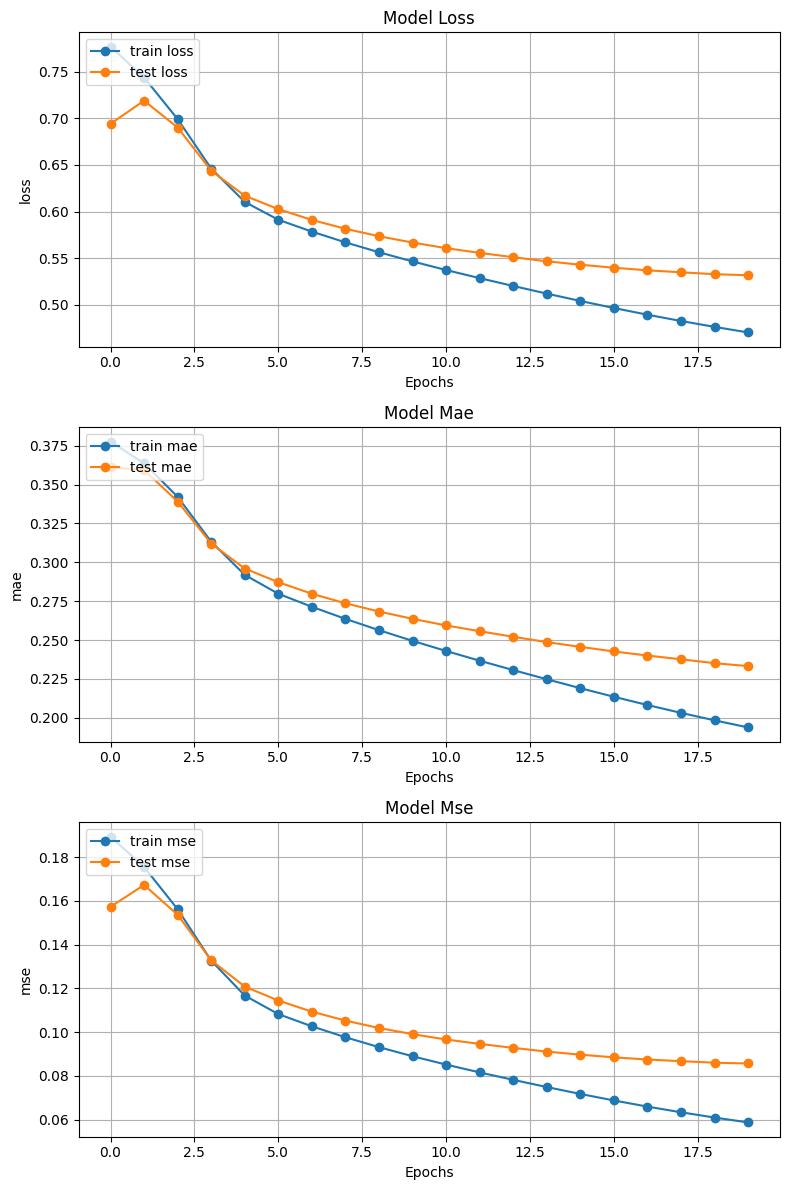

In [86]:
metrics = ["loss","mae","mse"]

fig,axes = plt.subplots(len(metrics),1,figsize=(8,len(metrics)*4))

for i,metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric],marker = "o",label = f"train {metric}")
    ax.plot(history.history[f"val_{metric}"],marker = "o",label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(metric)
    ax.legend(loc = "upper left")
    ax.grid(True)
plt.tight_layout()
plt.show()

In [90]:
def extract_weights(name,model):
    weights_layer = model.get_layer(name)
    weights = weights_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights


In [91]:
anime_weights = extract_weights("anime_embeddings",model)

In [92]:
user_weights = extract_weights("user_embeddings",model)